# 05. Deployment & MLOps (Inference, API, Drift)

## Overview
This notebook serves as the final integration test for the **deployment-ready** system. It bridges the gap between model training and production serving.

## Objectives
1.  **Artifact Loading**: Restore the trained `Sensitivity/StressPredictor` and its parameters.
2.  **Inference Diagnostics**: Visualize single-instance inputs and their corresponding model probabilities.
3.  **API Contract Verification**: Validate the `FastAPI` endpoint using a mock client to ensure JSON-serializability and correct schema handling.
4.  **Drift Monitoring**: Simulate a production shift (Old Users vs. New Users) to detect statistical **Data Drift** using the Kolmogorov-Smirnov test.

In [1]:
# 1. Imports & Setup
%load_ext autoreload
%autoreload 2

# Standard Library Imports
import sys
import importlib
from pathlib import Path

# Third-Party Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fastapi.testclient import TestClient

# Project-Specific Imports
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.api.app import app
from src.models.predict import StressPredictor
from src.config import load_config, PROJECT_ROOT
from src.visualization.plots import set_plot_style, visualize_inference, visualize_drift
from src.monitoring.drift_report import compute_drift

# Apply global configuration
set_plot_style()
config = load_config()

# Define Model Scope
MODEL_TYPE = 'deep' # Options: 'deep', 'logistic'
REPORTS_DIR = PROJECT_ROOT / "reports"
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "windows.parquet"

print("Setup Complete.")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Target Model: {MODEL_TYPE.upper()}")

Setup Complete.
Project Root: C:\Users\matteucc\Desktop\Portfolio_improvement\Wearable_stress_biomarker
Target Model: DEEP


## 1. Model Artifact Loading

We load the latest trained artifact from the `reports/` directory. This encapsulates:
*   **Weights**: The trained neural network state dict.
*   **Config**: Hyperparameters used during training.
*   **Normalizer**: The `RobustScaler` or other statistics required for preprocessing.

In [2]:
# 2. Load Trained Artifact

run_pattern = f"{MODEL_TYPE}_loso_*"
runs = sorted(list(REPORTS_DIR.glob(run_pattern)))

if not runs:
    raise FileNotFoundError(f"No trained artifacts found for '{run_pattern}'. Please run Notebook 04 first.")

latest_run = runs[-1]
print(f"Loading Artifact from: {latest_run.name}")

# Initialize Production Predictor
predictor = StressPredictor(latest_run)
print(f"Predictor Initialized: {predictor.model_type.upper()}")

Loading Artifact from: deep_loso_CHEST_20260118_183921
Predictor Initialized: DEEP


## 2. Live Data Stream Simulation

We use the validation dataset to simulate incoming "live" requests. In a real deployment, these arrays would arrive directly from the wearable device via Bluetooth/MQTT.

In [3]:
# 3. Load Live Data Stream

# Load full dataset for simulation
df = pd.read_parquet(DATA_PATH)

# Filter for Binary Labels (Simulation Scope)
df = df[df['label'].isin([1, 2])].copy()

# Add human-readable labels
df['label_str'] = df['label'].map({1: 'Baseline', 2: 'Stress'})

print(f"Simulation Data Loaded: {len(df)} windows.")
print(f"Subjects: {df['subject_id'].unique()}")

Simulation Data Loaded: 919 windows.
Subjects: ['S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9' 'S10' 'S11' 'S13' 'S14' 'S15'
 'S16' 'S17']


## 3. Inference Diagnostics

Here we visualize the model's decision process on individual windows. We look for:
*   **Input Quality**: Are there visible artifacts?
*   **Prediction**: Does the model output `Stress (Class 1)` or `Baseline (Class 0)`?
*   **Confidence**: Is the Softmax probability high (>0.9)?

--- TEST CASE 1: True Stress Sample ---


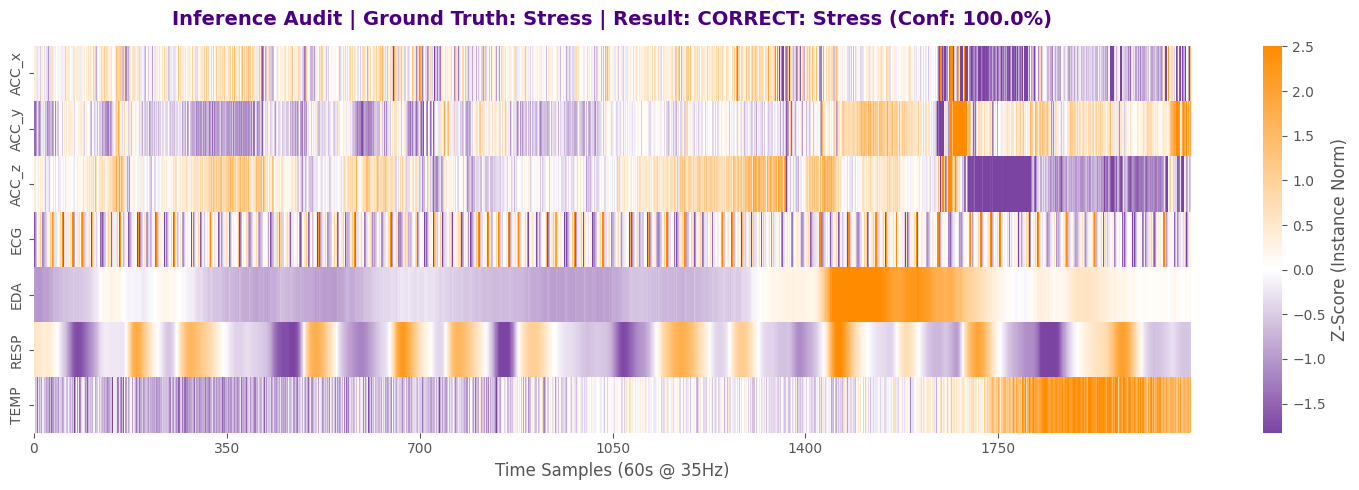

--- TEST CASE 2: True Baseline Sample ---


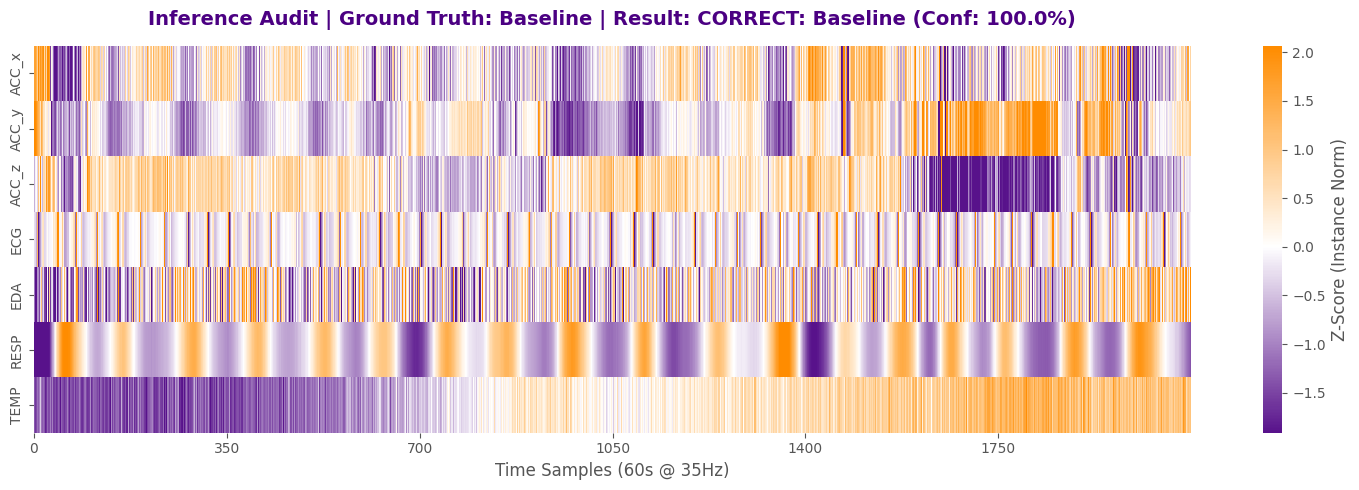

In [4]:
# 4. Inference Diagnostics

# Pick Random Samples
stress_sample = df[df['label'] == 2].sample(1).iloc[0]
baseline_sample = df[df['label'] == 1].sample(1).iloc[0]

# Visualize Case 1
print("--- TEST CASE 1: True Stress Sample ---")
_ = visualize_inference(stress_sample, predictor)
plt.show()

# Visualize Case 2
print("--- TEST CASE 2: True Baseline Sample ---")
_ = visualize_inference(baseline_sample, predictor)
plt.show()

## 4. Production API Verification

We test the **FastAPI** serving layer. This ensures that:
1.  Input JSON payloads are correctly parsed into `(1, 7, 2100)` arrays.
2.  The model executes within the async path.
3.  The response follows the schema: `{"prediction": str, "confidence": float}`.

In [5]:
# 5. Production API Verification

print("Simulating HTTP POST request to /predict endpoint...")

with TestClient(app) as client:
    
    # Construct Payload from Stress Sample
    # Convert numpy arrays to lists for JSON serialization
    payload = {
        "ACC_x": stress_sample['ACC_x'].tolist(),
        "ACC_y": stress_sample['ACC_y'].tolist(),
        "ACC_z": stress_sample['ACC_z'].tolist(),
        "ECG": stress_sample['ECG'].tolist(),
        "EDA": stress_sample['EDA'].tolist(),
        "RESP": stress_sample['RESP'].tolist(),
        "TEMP": stress_sample['TEMP'].tolist()
    }

    # Execute Request
    response = client.post("/predict", json=payload)

    # Validate Response
    if response.status_code == 200:
        res_json = response.json()
        print("\n--- 200 OK: API Response Info ---")
        print(f"Status:      {res_json['status']}")
        print(f"Prediction:  {res_json['prediction']}")
        print(f"Confidence:  {res_json['confidence']:.4f}")
        print(f"Raw Prob:    {res_json['probabilities']}")
    else:
        print(f"--- ERROR {response.status_code} ---")
        print(response.text)

Simulating HTTP POST request to /predict endpoint...
2026-01-18 19:05:07,987 - src.api.app - INFO - Loading Model Artifact: deep_loso_CHEST_20260118_183921
2026-01-18 19:05:08,004 - src.api.app - INFO - StressPredictor initialized successfully (deep).

--- 200 OK: API Response Info ---
Status:      Success
Prediction:  Stress
Confidence:  1.0000
Raw Prob:    {'Baseline': 1.1348165571689606e-05, 'Stress': 0.9999886751174927}


## 5. MLOps: Data Drift Monitoring

We simulate a **Data Drift** scenario where the model encounters a new population ("New Users").

**Methodology**:
*   **Reference Set**: Data from the original training subjects.
*   **Current Set**: Data from unseen subjects.
*   **Test**: Two-sample **Kolmogorov-Smirnov (KS) Test**.

**Interpretation**:
If `Drift Detected` is flagged (p-value < 0.05) for key features (e.g., `EDA_mean`), it suggests the new users have physiologically distinct baselines. In production, this would trigger a **Retraining Alert**.

Reference Population (Training): ['S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8']
Current Population (New Users):  ['S9' 'S10' 'S11' 'S13' 'S14' 'S15' 'S16' 'S17']

Analyzing drift across 100 samples...
2026-01-18 19:05:08,087 - src.monitoring.drift_report - INFO - Extracting monitoring features...
--- Drift Report: 10/15 features showed significant distributional shift (p<0.05). ---


,Feature,P-Value,Drift Detected,Ref Mean,Cur Mean
3,ACC_y_mean,1.070076e-12,True,-0.078299,0.012088
9,EDA_mean,6.422180e-10,True,6.334828,3.336774
12,RESP_std,2.749465e-08,True,2.734605,3.653908
10,EDA_std,8.001544e-07,True,0.098016,0.023593
6,ACC_z_std,6.281177e-05,True,0.029412,0.055612
13,TEMP_mean,1.293506e-03,True,33.477009,34.042027
7,ECG_mean,1.293506e-03,True,0.001155,0.001023
14,TEMP_std,3.729492e-03,True,0.189526,0.024796
4,ACC_y_std,2.405580e-02,True,0.020931,0.027056
2,ACC_x_std,3.638429e-02,True,0.017771,0.019046


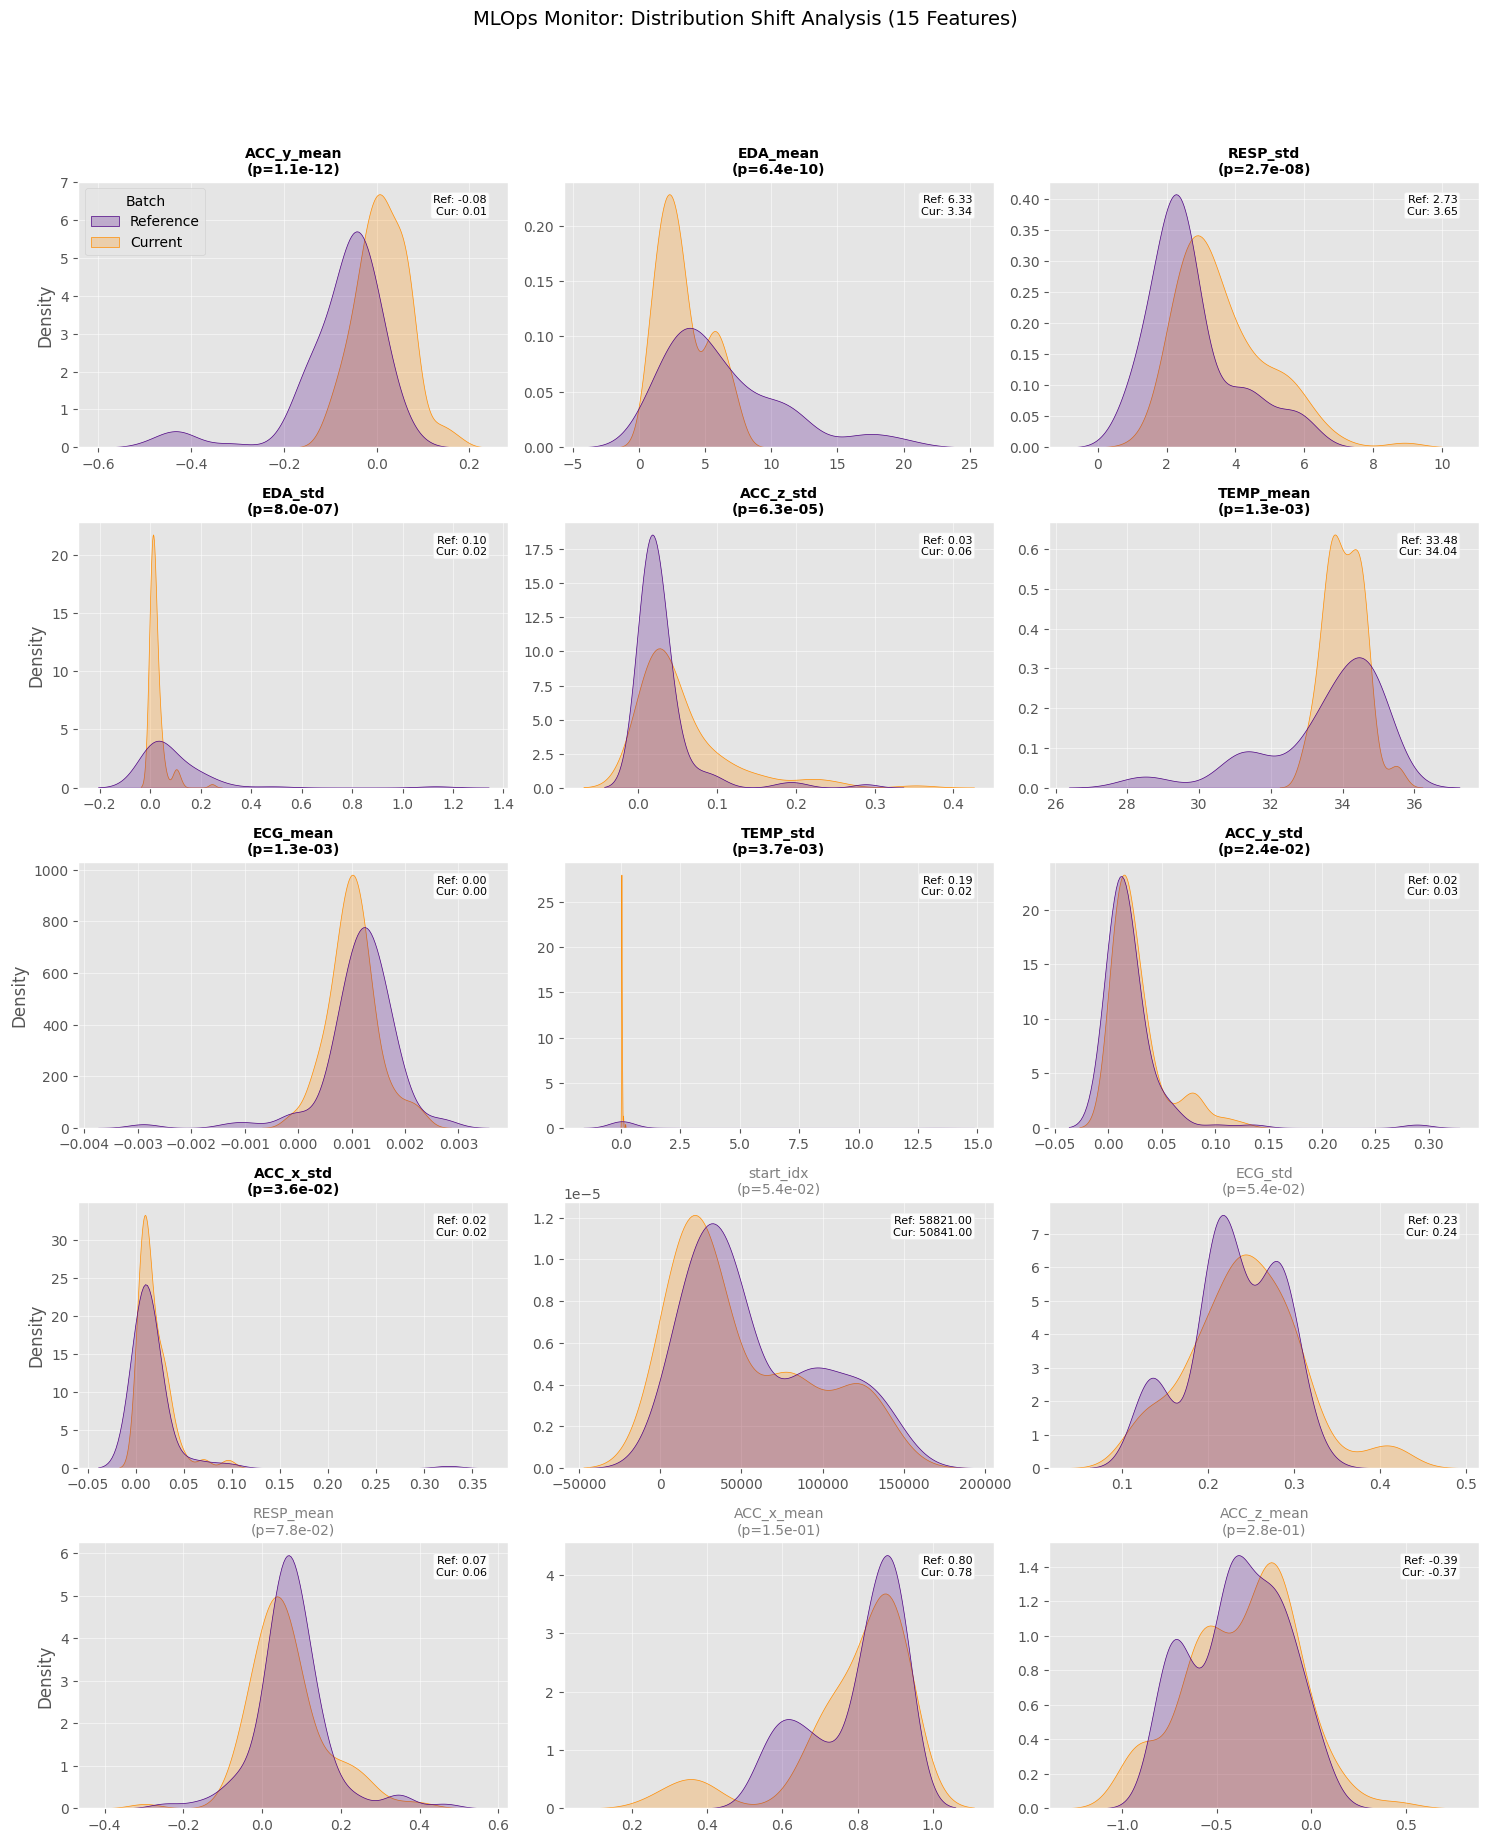

In [6]:
# 6. Drift Monitoring (New vs Old Users)

# Split Populations
subjects = df['subject_id'].unique()
mid_idx = len(subjects) // 2

ref_subjects = subjects[:mid_idx]
curr_subjects = subjects[mid_idx:]

print(f"Reference Population (Training): {ref_subjects}")
print(f"Current Population (New Users):  {curr_subjects}")

# Create Batches (N=100 samples each)
BATCH_SIZE = 100
df_ref = df[df['subject_id'].isin(ref_subjects)].sample(BATCH_SIZE, replace=True, random_state=42)
df_curr = df[df['subject_id'].isin(curr_subjects)].sample(BATCH_SIZE, replace=True, random_state=42)

# Compute Drift Metrics
print(f"\nAnalyzing drift across {BATCH_SIZE} samples...")
drift_report = compute_drift(df_ref, df_curr)

# Visualize Dashboard
drift_df = visualize_drift(drift_report, df_ref, df_curr)
display(drift_df)